# Описание

Во всех файлах столбец **customerID** содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.


Описание услуг
Оператор предоставляет два основных типа услуг:   
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  


Также доступны такие услуги:  
Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);  
Выделенная линия технической поддержки (TechSupport);   
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);  
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

In [1]:
!pip install scikit-learn==1.4.2

In [2]:
!pip install missingno

In [3]:
!pip install phik

## Загрузка данных

<!-- хи квадрат для проверки груп на гипотезы.

шап
анализ важности фактора это шаг
проблема мульти коланиарность 
рекал присижен 
рандомазер быстрее чем грид серч -->

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import missingno as msno

import phik
from phik.report import plot_correlation_matrix
from phik import report

from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from functools import reduce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  LabelEncoder
from sklearn.dummy import DummyClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
RANDOM = 31052024

Небольшая функция для чтения файлов

In [2]:
def pach(pach_1,pach_2, pach_3):
    if os.path.exists(pach_1):
        data = pd.read_csv(pach_1, parse_dates=[0], index_col=[0])
    elif os.path.exists(pach_2):
        data = pd.read_csv(pach_2, parse_dates=[0], index_col=[0])
    elif os.path.exists(pach_3):
        data = pd.read_csv(pach_2, parse_dates=[0], index_col=[0])
    else:
        data = pd.DataFrame(['Houston, we have a problem!'])


    return data

Подготовим пути.

In [3]:
# информация о договоре;
contract_new_pc = 'C:\\Users\\1537d\\Downloads\\contract_new.csv'
contract_new_s = '/datasets/contract_new.csv'
review_1 = ''

# персональные данные клиента;
personal_new_pc = "C:\\Users\\1537d\\Downloads\\personal_new.csv"
personal_new_s = '/datasets/personal_new.csv'
review_2 = ''

# информация об интернет-услугах;
internet_new_pc = "C:\\Users\\1537d\\Downloads\\internet_new.csv"
internet_new_s = '/datasets/internet_new.csv'
review_3 = ''

# информация об услугах телефонии.
phone_new_pc = "C:\\Users\\1537d\\Downloads\\phone_new.csv"
phone_new_s = '/datasets/phone_new.csv'
review_4 = ''

### Данные по договорам.

Ознакомимся с имеющимися данными.

Информация о договоре:
* **customerID** — идентификатор пользователя;
* **BeginDate** — дата начала действия договора;
* **EndDate** — дата окончания действия договора;
* **Type** — тип оплаты: раз в год-два или ежемесячно;
* **PaperlessBilling** — электронный расчётный лист;
* **PaymentMethod** — тип платежа;
* **MonthlyCharges** — расходы за месяц;
* **TotalCharges** — общие расходы абонента.

In [4]:
df_contract = pach(contract_new_pc,contract_new_s,review_1)
df_contract.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Посмотрим на уникальные значения

In [6]:
for i in df_contract:
    print(i, df_contract[i].sort_values().unique())

BeginDate ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '2019-07-01'
 '2019-08-01' '2019-09-01' '2019-10-01' '2019-11-01' '2019-12-01'


Обратим внимание на два столбца **EndDate** — это наш целевой признак здесь мы видим, что пользователи, которые не расторгли контракт на момент 01-02-2020 имеют отметку **No**, а у пользователей расторгнувший контракт стоит дата его завершения. **TotalCharges** - общая сумма которую заплатил пользователь за время использования услуг. В этом столбце мы видим, что есть уникальное значение в котором только пробел.

### Данные клиентов.

Персональные данные клиента:
* **customerID** — идентификатор пользователя;
* **gender** — пол;
* **SeniorCitizen** — является ли абонент пенсионером;
* **Partner** — есть ли у абонента супруг или супруга;
* **Dependents** — есть ли у абонента дети.

In [7]:
df_personal = pach(personal_new_pc,personal_new_s,review_2)
df_personal.head(3)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No


In [8]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [9]:
for i in df_personal:
    print(i, df_personal[i].sort_values().unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['No' 'Yes']
Dependents ['No' 'Yes']


Всего 4 столбца с данными о семье, поле и пенсионном статусе. Все признаки бинарны.

### Данные по услугам интернета.

Информация об интернет-услугах:
* **customerID** — идентификатор пользователя;
* **InternetService** — тип подключения;
* **OnlineSecurity** — блокировка опасных сайтов;
* **OnlineBackup** — облачное хранилище файлов для резервного копирования данных;
* **DeviceProtection** — антивирус;
* **TechSupport** — выделенная линия технической поддержки;
* **StreamingTV** — стриминговое телевидение;
* **StreamingMovies** — каталог фильмов.

In [10]:
df_internet = pach(internet_new_pc,internet_new_s,review_3)
df_internet.head(3)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [11]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [12]:
for i in df_internet:
    print(i, df_internet[i].sort_values().unique())

InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['No' 'Yes']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


Здесь 7 столбцов в которых отмечены данные о подключенной дополнительно услуге и тип подключения.

### Данные по услугам телефонии.

Информация об услугах телефонии.
* **customerID** — идентификатор пользователя;
* **MultipleLines** — подключение телефона к нескольким линиям одновременно.

In [13]:
df_phone = pach(phone_new_pc,phone_new_s,review_4)
df_phone.head(3)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No


In [14]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [15]:
df_phone['MultipleLines'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

Иметься два значения отметка о нескольких подключенных номерах или только один номер.

### Общая таблица.

Объединим всё таблицы в общую.

In [16]:
df = df_contract.merge(df_personal, on='customerID', how='left')
df= df.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')
# data_subcategory['TotalCharges'] = data_subcategory['TotalCharges'].astype(float)
df.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Посмотрим на пропуски.

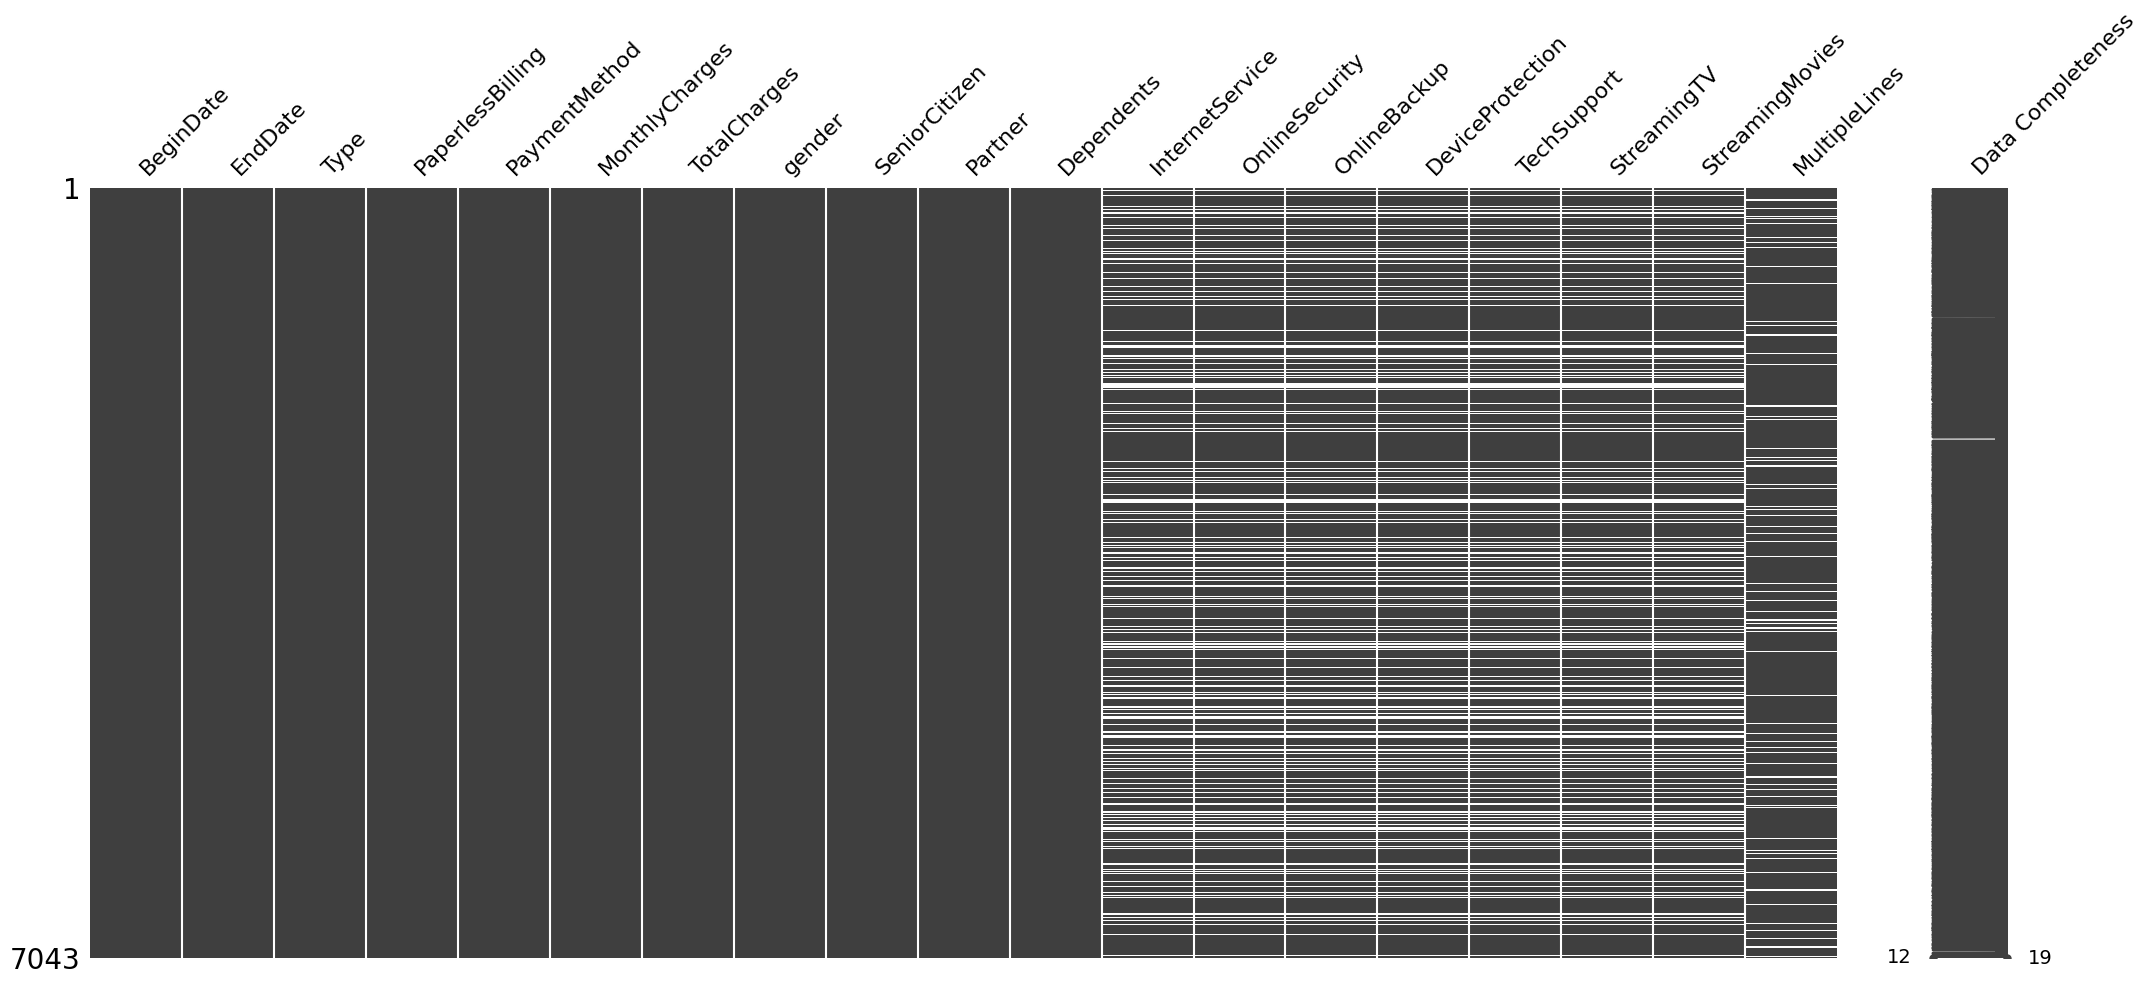

In [18]:
msno.matrix(df, labels=True);

У нас получился дата сет из 19 столбцов с количеством строк от 7043 до 5517 нам надо заполнить пропуски также поработать с типом данных

## Исследовательский анализ и предобработка данных

Выполните исследовательский анализ каждого датафрейма и при необходимости выполните предобработку. Сделайте выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

Взглянем на значения с пробелом в **'TotalCharges'**

In [19]:
df.loc[df['TotalCharges'] == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Мы видим не большое количество без каких либо данных об оплате, но если обратить внимания все эти пользователи были подключены только что, и ещё не успели совершить оплату.

Заполним всё ноликами, и переведем данный столбец в подходящий тип данных *float64*

In [20]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [21]:
df['TotalCharges'] = df['TotalCharges'].astype('float64')
df['TotalCharges'].sort_values().unique()

array([   0.  ,   19.05,   19.1 , ..., 9068.36, 9218.88, 9221.38])

Перейдем к столбцу с целевым признаком. Добавим новый столбец в который перезапишем данные используя 0 и 1

In [22]:
df.loc[df_contract['EndDate'] != 'No', 'target'] = 1
df.loc[df_contract['EndDate'] == 'No', 'target'] = 0

Посмотрим на результат и баланс.

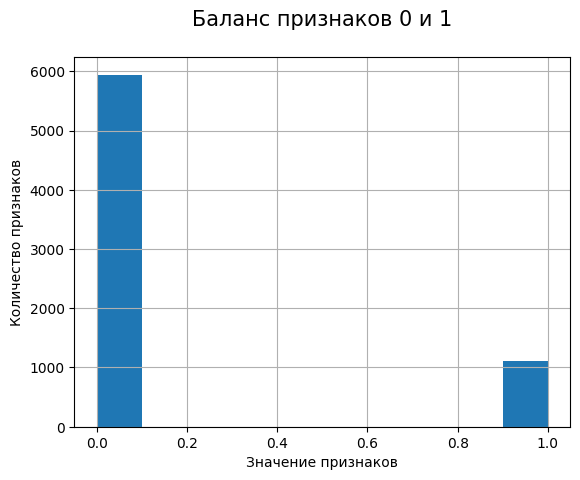

In [23]:
df['target'] = df['target'].astype('int32') 
df['target'].hist()
plt.title("Classes balance");
df['target'].value_counts()
plt.title('Баланс признаков 0 и 1' + "\n", fontsize=15)
plt.xlabel('Значение признаков', fontsize=10)
plt.ylabel('Количество признаков', fontsize=10);

Заполним пропуски в двух столбцах **InternetService** и **MultipleLines** значением *'No_service'* в описание упоминалось, что отсутствие данных означает об отсутствие данной услуги.
Все остальные колонки(**OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies**) заполни значениями *'No'*.

In [24]:
df[['InternetService','MultipleLines']] = df[['InternetService','MultipleLines']].fillna('No_service')
print(df['InternetService'].sort_values().unique())
print(df['MultipleLines'].sort_values().unique())

['DSL' 'Fiber optic' 'No_service']
['No' 'No_service' 'Yes']


Сделаем более понятными категории в столбце с тарифами подключенных телефонов.

In [25]:
df['phone'] = df['MultipleLines'].apply(lambda x: 'One' if x=='No' else ('Multi' if x=='Yes' else 'No_phone'))
df['phone'].value_counts()

phone
One         3390
Multi       2971
No_phone     682
Name: count, dtype: int64

In [26]:
df = df.fillna('No')

Взглянем на результаты заполнения. 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

Разобьём некоторые данные на категории и группы. Для более удобного ознакомления.
Разделим всех пользователей на 3 категории по количеству используемых услуг, есть телефон, есть интернет или все и сразу.

In [28]:
def typa_service(row):
    internet = row['InternetService']
    phone = row['phone']
    if (internet=='Fiber optic' or internet=='DSL') and (phone=='One' or phone=='Multi'):
        return 'internet_phone'
    elif (internet=='Fiber optic' or internet=='DSL'):
        return 'internet'
    elif phone=='One' or phone=='Multi':
        return 'phone'
    else:
        return 'Unknown'

In [29]:
df['service'] = df.apply(typa_service, axis=1)
df['service'].value_counts()

service
internet_phone    4835
phone             1526
internet           682
Name: count, dtype: int64

Посчитаем сколько услуг использует каждый пользователь.

In [30]:
def services_count (row):
    count = 0
    if row['InternetService'] != 'No_service':
        count += 1
    if row['OnlineSecurity'] == 'Yes':
        count += 1
    if row['OnlineBackup'] == 'Yes':
        count += 1
    if row['DeviceProtection'] == 'Yes':
        count += 1
    if row['TechSupport'] == 'Yes':
        count += 1
    if row['StreamingTV'] == 'Yes':
        count += 1
    if row['StreamingMovies'] == 'Yes':
        count += 1
    if row['MultipleLines'] != 'No_service':
        count += 1
        return count

In [31]:
df['services_count'] = df.apply(services_count, axis=1).astype('float64')
df['services_count'].value_counts()

services_count
1.0    1526
5.0     966
4.0     889
3.0     852
6.0     756
2.0     613
7.0     500
8.0     259
Name: count, dtype: int64

Также сгруппируем пользователей по ежемесячной плате.

In [32]:
def group_buy (x):
    if x <= 20:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x <= 80:
        return 4
    elif x <= 100:
        return 5
    else:
        return 6

In [33]:
df['months_buy_gruop'] = df['MonthlyCharges'].apply(group_buy)
df['months_buy_gruop'].value_counts()

months_buy_gruop
5    1764
4    1459
2    1182
3    1080
6     902
1     656
Name: count, dtype: int64

In [34]:
df.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,phone,service,services_count,months_buy_gruop
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,No_service,0,No_phone,internet,NaN,2
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,0,One,internet_phone,4.0,3
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,0,One,internet_phone,4.0,3


Посчитаем количество дней которые пользователь с нами

In [35]:
df['EndDate'] = df['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [36]:
def date_convert(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

date_convert(df, 'BeginDate')
date_convert(df, 'EndDate')

In [37]:
df['EndDate'].value_counts()

EndDate
2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

In [38]:
df['period']=(df['EndDate']-df['BeginDate'])/np.timedelta64(1,'D')
df['period'] = df['period'].astype('int')
df['period'].sort_values().unique()

array([   0,   28,   30,   31,   59,   61,   62,   90,   91,   92,  121,
        122,  123,  151,  153,  181,  182,  183,  184,  212,  213,  214,
        215,  242,  243,  244,  245,  273,  274,  275,  276,  303,  304,
        305,  306,  334,  335,  336,  337,  365,  366,  393,  395,  396,
        397,  424,  425,  426,  427,  454,  456,  457,  458,  485,  486,
        487,  488,  489,  515,  516,  517,  518,  519,  546,  547,  548,
        549,  550,  577,  578,  579,  580,  607,  608,  609,  610,  611,
        638,  639,  640,  641,  668,  669,  670,  671,  672,  699,  700,
        701,  702,  703,  730,  731,  759,  760,  761,  762,  789,  790,
        791,  792,  793,  820,  821,  822,  823,  850,  851,  852,  853,
        854,  881,  882,  883,  884,  911,  912,  913,  914,  915,  942,
        943,  944,  945,  946,  972,  973,  974,  975,  976, 1003, 1004,
       1005, 1006, 1007, 1034, 1035, 1036, 1037, 1064, 1065, 1066, 1067,
       1068, 1095, 1096, 1124, 1125, 1126, 1127, 11

In [39]:
df.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,phone,service,services_count,months_buy_gruop,period
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No_service,0,No_phone,internet,NaN,2,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,No,No,No,0,One,internet_phone,4.0,3,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,0,One,internet_phone,4.0,3,123


Так же разобьём все на категории месяц, полгода, 1год, 2года, 3года, 5 лет и больше.

In [40]:
def group_days (x):
    if x < 32:
        return '1 months'
    elif x < 184:
        return '6 months'
    elif x < 366:
        return '1'
    elif x < 731:
        return '2'
    elif x < 1096:
        return '3'
    elif x <= 1827:
        return '5'    
    else:
        return '6>'

In [41]:
df['grup_day'] = df['period'].apply(group_days)
df['grup_day'].value_counts()

grup_day
5           1537
2           1261
3           1043
6>           992
1            982
6 months     979
1 months     249
Name: count, dtype: int64

Посмотрим на результат

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

In [43]:
df.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,StreamingTV,StreamingMovies,MultipleLines,target,phone,service,services_count,months_buy_gruop,period,grup_day
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No_service,0,No_phone,internet,NaN,2,31,1 months
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,No,No,0,One,internet_phone,4.0,3,1036,3
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,0,One,internet_phone,4.0,3,123,6 months


Посмотрим на распределение групп и признаков. Для этого приведём некоторые столбцы нужному типу.

In [44]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['services_count'] = df['services_count'].astype('object')
df['months_buy_gruop'] = df['months_buy_gruop'].astype('object')

Distribution of classes of a categorical variable: Type


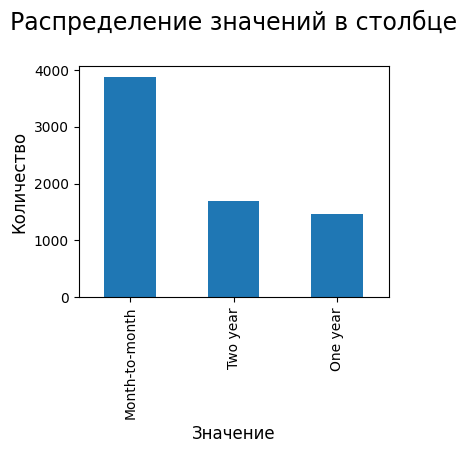

Distribution of classes of a categorical variable: PaperlessBilling


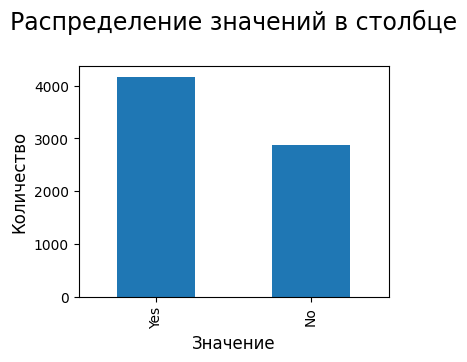

Distribution of classes of a categorical variable: PaymentMethod


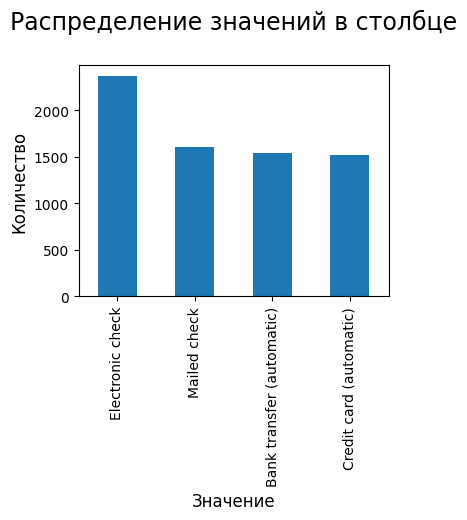

Distribution of classes of a categorical variable: gender


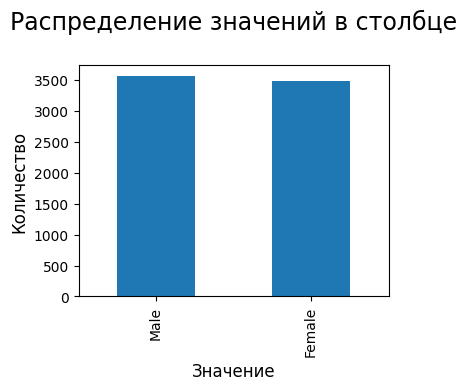

Distribution of classes of a categorical variable: SeniorCitizen


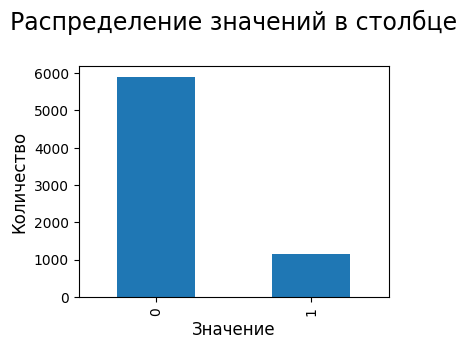

Distribution of classes of a categorical variable: Partner


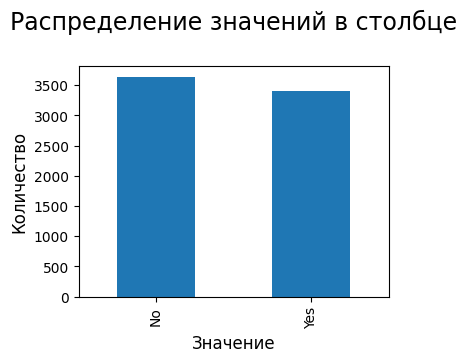

Distribution of classes of a categorical variable: Dependents


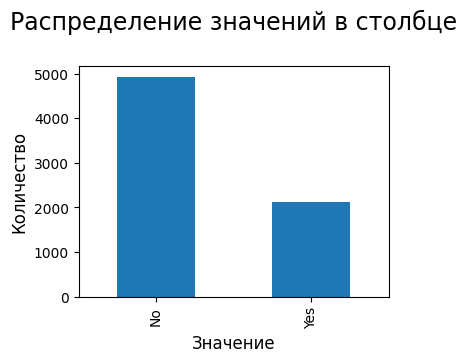

Distribution of classes of a categorical variable: InternetService


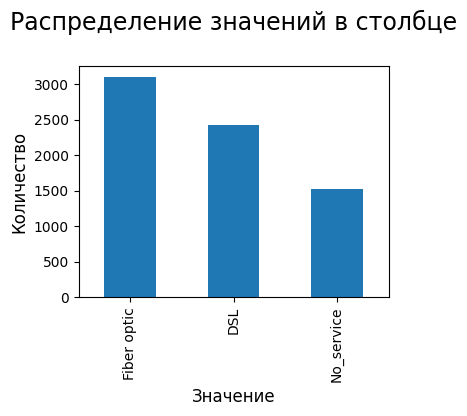

Distribution of classes of a categorical variable: OnlineSecurity


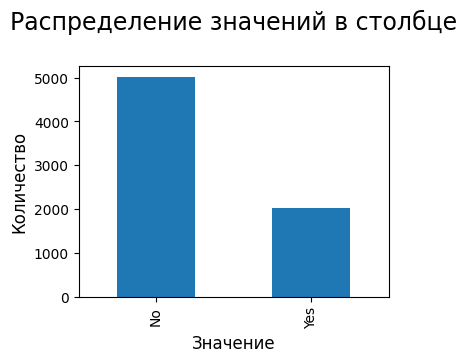

Distribution of classes of a categorical variable: OnlineBackup


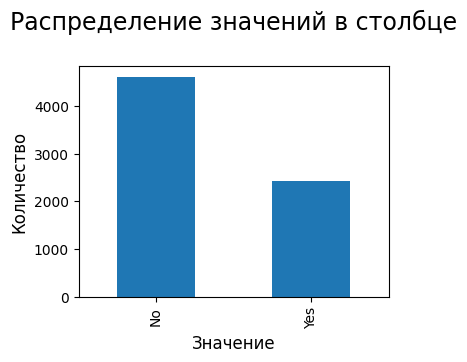

Distribution of classes of a categorical variable: DeviceProtection


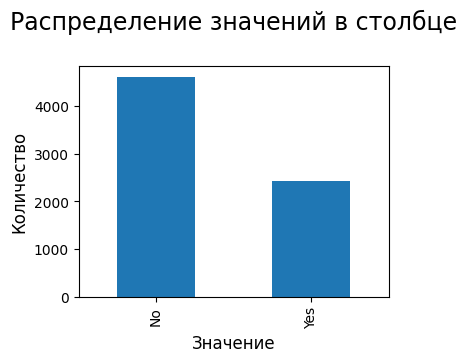

Distribution of classes of a categorical variable: TechSupport


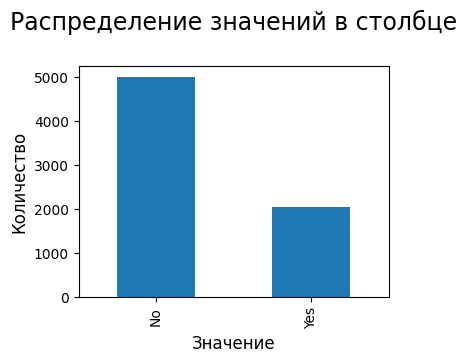

Distribution of classes of a categorical variable: StreamingTV


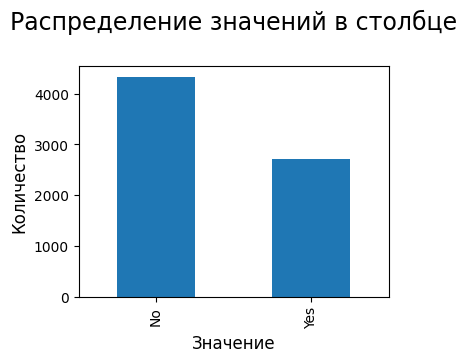

Distribution of classes of a categorical variable: StreamingMovies


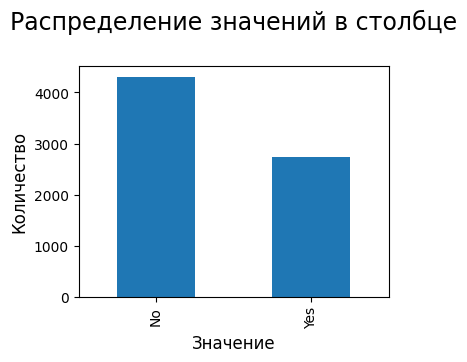

Distribution of classes of a categorical variable: MultipleLines


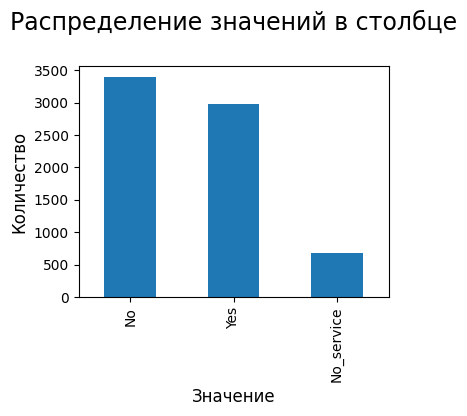

Distribution of classes of a categorical variable: phone


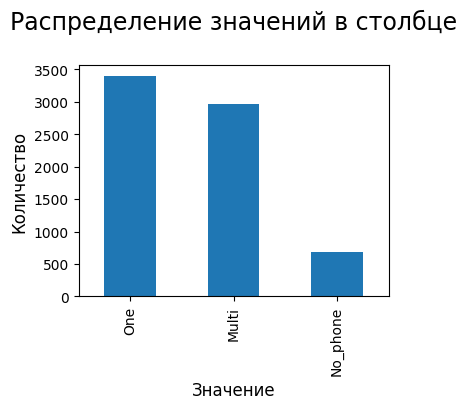

Distribution of classes of a categorical variable: service


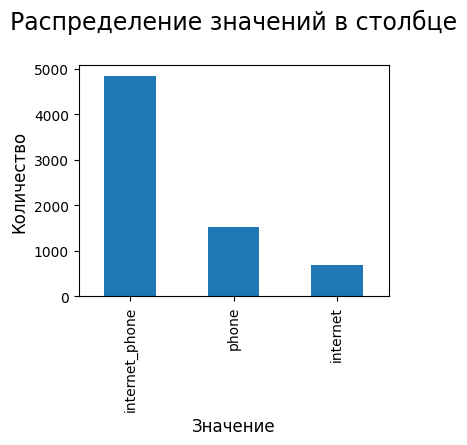

Distribution of classes of a categorical variable: services_count


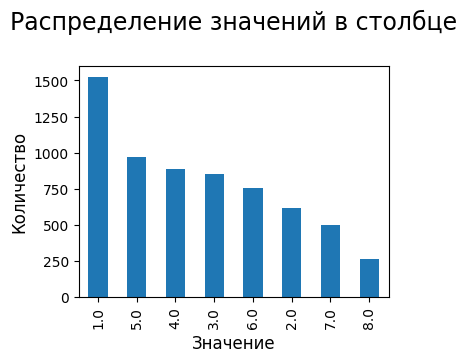

Distribution of classes of a categorical variable: months_buy_gruop


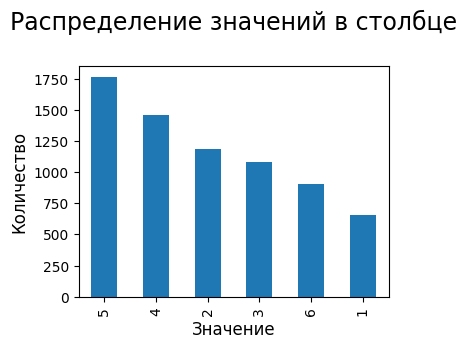

Distribution of classes of a categorical variable: grup_day


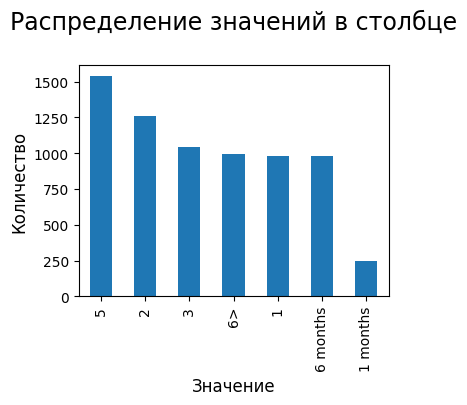

In [45]:
categorical_features = df.select_dtypes(include='object').columns.to_list()

for i in df[categorical_features]:
    print('Distribution of classes of a categorical variable:', i)
    df[i].value_counts().plot(kind='bar', figsize=(4,3))
    # plt.show();
    plt.title('Распределение значений в столбце' + "\n", fontsize=17)
    plt.xlabel('Значение', fontsize=12)
    plt.ylabel('Количество', fontsize=12);
    plt.show();

На графике *Type* мы видим, что преобладает большенство людей подключающие тариф с ежемесячной оплатой. А вот контракты на год и два почти равнозначны хотя на год немного чаще.
Большенство пользователей предпочитают электронный чек об оплате, так на графике **PaymentMethod** мы видим что большенство людей выбирают электронный способ оплаты.
остальные три типа оплаты имеют практически равное распределение.
Среди пользователей практически равное распределение женьщин и мужчин, а вот пенсионеров среди них примерно 15%. Так же мы видим, что пользователей с партнерами не намного меньше чем одиноких, а вот пользователей с детьми почти в двое меньше чем одиноких.

Всего около 20% всех пользователей пользуються только услугами связи без интернета. В среднем каждой интернет услугу пользуються от 30% до 60% от общего числа всех пользователей. Если сказать проще каждая услуга используеться на 50% от общего числа людей. А вот сервис ТВ и библиотека фильмов более востребована. 

Примерно 10% всех абонентов не используют услуги связи. Чаще всего люди подключают комплект интернет и связь. Меньше всего только интернет.

Из графика **service_count** мы видим что более 20% подключают хотябы одну доп услугу и менее 5% берут максимум. Чаще всего пользователи платят меньше 100 у.е. и лишь чуть больше 10% пользователей платят ежемесячно больше. 

Среди наших клиентов очень много лояльных, тех кто с нами больше 5 лет. а вот новых особо не прибавляеться. особенно последний месяц.

Взглянем на имеющеюся сейчас корреляцию между признаками 

Давайте взглянем на корреляцию наших признаков, 

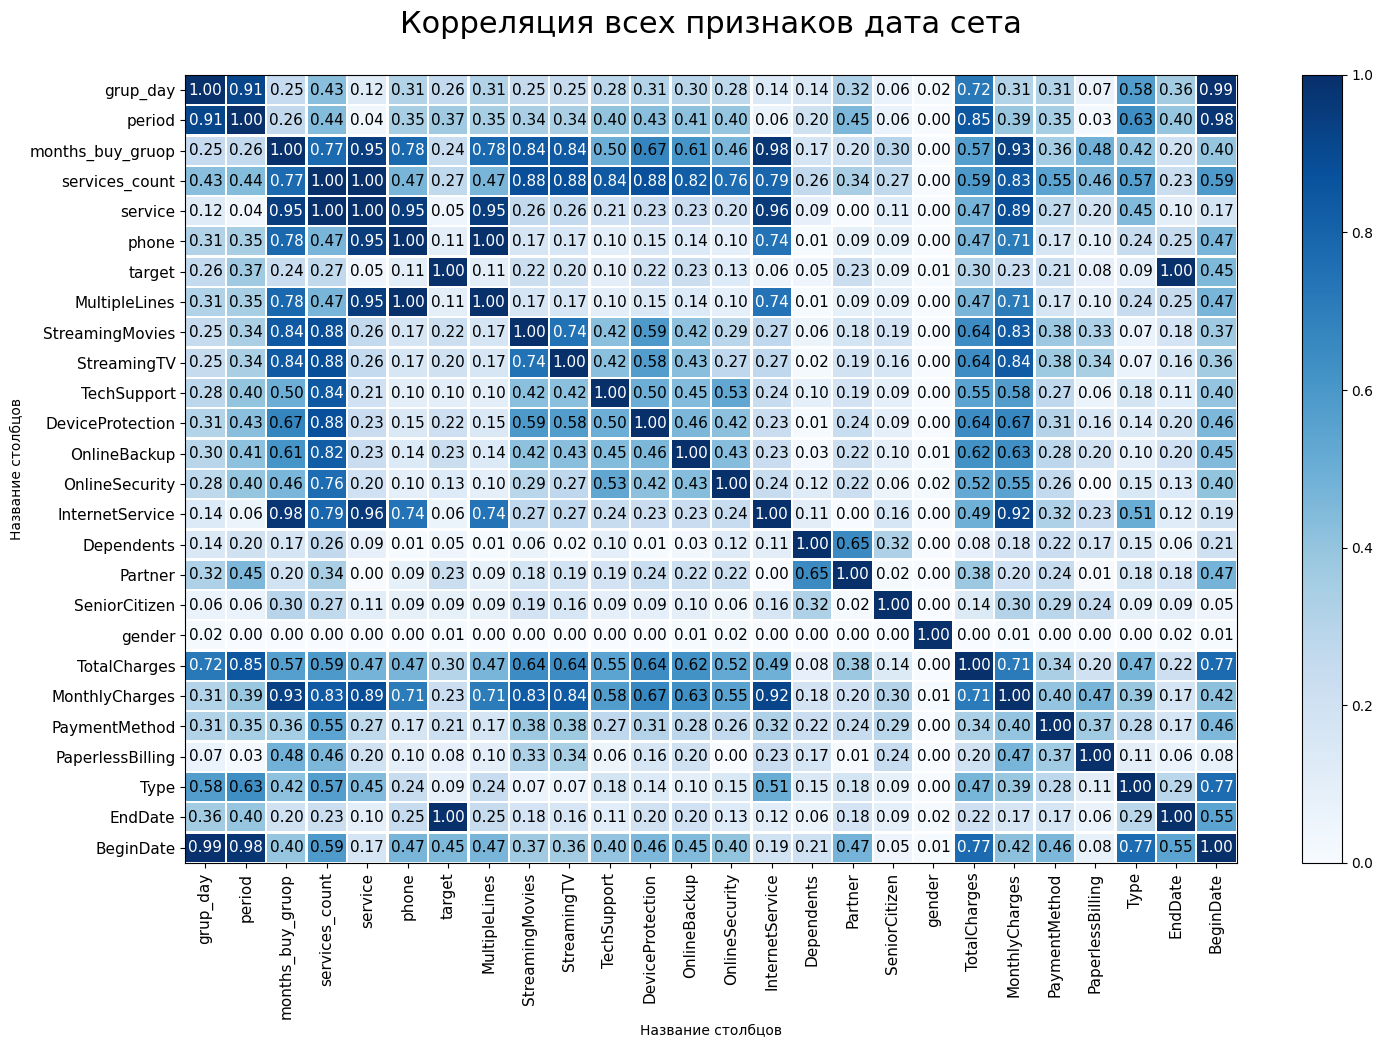

In [46]:
interval_cols = ['TotalCharges', 'MonthlyCharges', 'period']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(15, 10))
plt.tight_layout()
plt.title('Корреляция всех признаков дата сета' + "\n", fontsize=22)
plt.xlabel('Название столбцов', fontsize=10)
plt.ylabel('Название столбцов', fontsize=10);

Обратим особое внимание на эту и следующие таблицы.  Здесь можно увидеть, что признак гендера совершенно не на что, не влияет, а вот наличие или отсутствие партнера более значимы. 4 новых признака имеют не плохую корреляцию, а вот сервис и количество подключенных номеров не большое значение. Также мы видим, что **End Date** полностью зависим с нашим целевым признаком, что естественно ведь из этого признака мы составили столбец **target**.

Посмотрим на глобальную корреляцию.
Глобальный коэффициент корреляции является полезной мерой, выражающей общую корреляцию одной переменной со всеми другими переменными в наборе данных. 

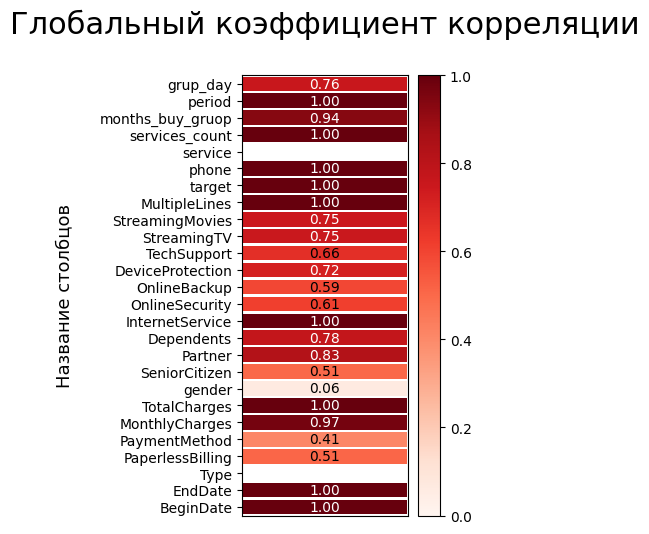

In [47]:

global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,5),
                        color_map="Reds", title=r"$g_k$",
                        fontsize_factor=1)
plt.tight_layout()
plt.title('Глобальный коэффициент корреляции' + "\n", fontsize=22)
plt.ylabel('Название столбцов' + "\n", fontsize=13);

На данном графике мы видим, чтo **service, Type, gender** практически не коррелируют с другими признаками.

Также посмотрим на значимость корреляции, наших признаков.

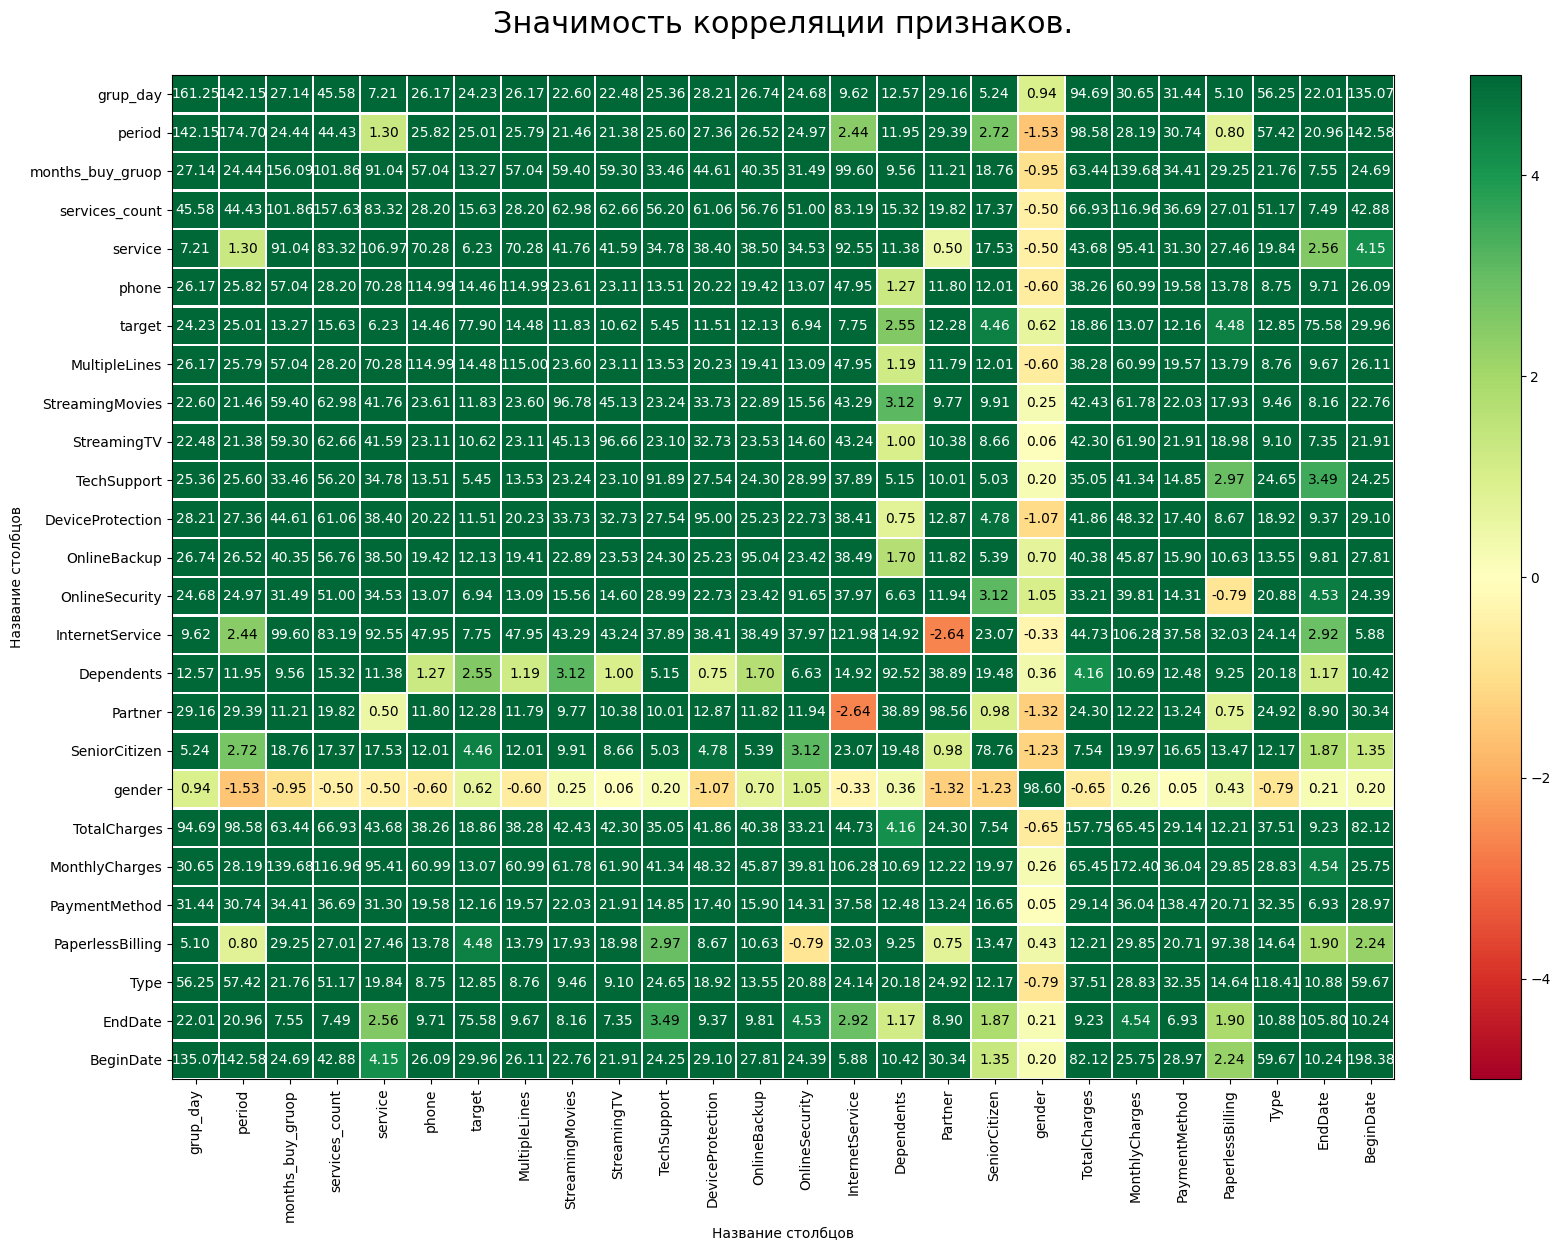

In [49]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(17, 12))
plt.tight_layout()
plt.title('Значимость корреляции признаков.' + "\n", fontsize=22)
plt.xlabel('Название столбцов', fontsize=10)
plt.ylabel('Название столбцов', fontsize=10);

Здесь на пересечение со столбцом **target** плохо сочетаются дети и гендер.

Просмотрев, данные по корреляции, мы можем сделать вывод какие данные можно убрать.

Избавимся от лишних признаков, что облегчит обучение наших моделей.

In [50]:
d_10 = ['Type', 'gender', 'SeniorCitizen','Dependents','BeginDate', 'EndDate', 'PaperlessBilling','service', 'grup_day'] # до 10
df = df.drop(columns=d_10)

In [51]:
df.head(3)

,PaymentMethod,MonthlyCharges,TotalCharges,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,phone,services_count,months_buy_gruop,period
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,Electronic check,29.85,31.04,Yes,DSL,No,Yes,No,No,No,No,No_service,0,No_phone,NaN,2,31
5575-GNVDE,Mailed check,56.95,2071.84,No,DSL,Yes,No,Yes,No,No,No,No,0,One,4.0,3,1036
3668-QPYBK,Mailed check,53.85,226.17,No,DSL,Yes,Yes,No,No,No,No,No,0,One,4.0,3,123


In [52]:
df.shape

(7043, 17)

### Обучение моделей машинного обучения

Перейдем к подготовке обучающей и тестовой выборки, здесь мы разделим наш дата сет на 4 части, закодируем и за скалируем. 

In [53]:
features = df.drop(columns='target')
target = df['target']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM, stratify = target)

In [55]:
encoder_ohe = OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False)
encoder_ohe

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [56]:
# #категориальные признаки для OHE
name_features_ohe = X_train.select_dtypes(include='object').columns.to_list()
print(name_features_ohe)

name_features_num = features.select_dtypes(exclude='object').columns.to_list()
name_features_num

['PaymentMethod', 'Partner', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'phone', 'services_count', 'months_buy_gruop']


['MonthlyCharges', 'TotalCharges', 'period']

In [57]:
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train[name_features_ohe])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [58]:
# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train[name_features_ohe])

In [59]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train = X_train.drop(name_features_ohe, axis=1)

# создаём скелер
scaler = StandardScaler().fit(X_train[name_features_num])

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train[name_features_num] = scaler.transform(X_train[name_features_num])
# смотрим на результат

# смотрим на результат
X_train.head()

,MonthlyCharges,TotalCharges,period,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,InternetService_Fiber optic,InternetService_No_service,OnlineSecurity_Yes,...,services_count_5.0,services_count_6.0,services_count_7.0,services_count_8.0,services_count_nan,months_buy_gruop_2,months_buy_gruop_3,months_buy_gruop_4,months_buy_gruop_5,months_buy_gruop_6
customerID,,,,,,,,,,,,,,,,,,,,,
9081-WWXKP,-1.482389,-0.697654,-0.022246,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4611-ANLQC,-0.491881,0.422312,1.355716,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6732-FZUGP,0.998866,1.324452,0.779982,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3097-NNSPB,-0.525119,-0.850399,-1.043661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0742-LAFQK,1.140130,2.382598,1.889073,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<!-- Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра. -->

In [60]:
def ohe_scal(features):
    features[
        encoder_ohe.get_feature_names_out()
    ] = encoder_ohe.transform(features[name_features_ohe])

    features = features.drop(name_features_ohe, axis=1)
    features[name_features_num] = scaler.transform(features[name_features_num])
    return features
X_test = ohe_scal(X_test)
X_test.head()

,MonthlyCharges,TotalCharges,period,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,InternetService_Fiber optic,InternetService_No_service,OnlineSecurity_Yes,...,services_count_5.0,services_count_6.0,services_count_7.0,services_count_8.0,services_count_nan,months_buy_gruop_2,months_buy_gruop_3,months_buy_gruop_4,months_buy_gruop_5,months_buy_gruop_6
customerID,,,,,,,,,,,,,,,,,,,,,
2580-ATZSQ,-0.116286,0.889064,1.579288,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5397-NSKQG,-0.463628,0.615364,1.669885,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7641-TQFHN,1.186664,1.043510,0.421975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9801-NOSHQ,-1.497346,-0.767931,-0.286732,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0895-LNKRC,-1.508979,-0.945735,-1.043661,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
print("Размеры выборок с признаками")
print(X_train.shape, X_test.shape)
print("Размер выборок с целевым признаком")
print(y_train.shape, y_test.shape)

Размеры выборок с признаками
(5282, 32) (1761, 32)
Размер выборок с целевым признаком
(5282,) (1761,)


У нас получилось несколько обучающих и тестовых выборок, их мы будем использовать в зависимости от наших моделей.

Посмотрим на баланс, есть ли в выборках значения каждой категории.

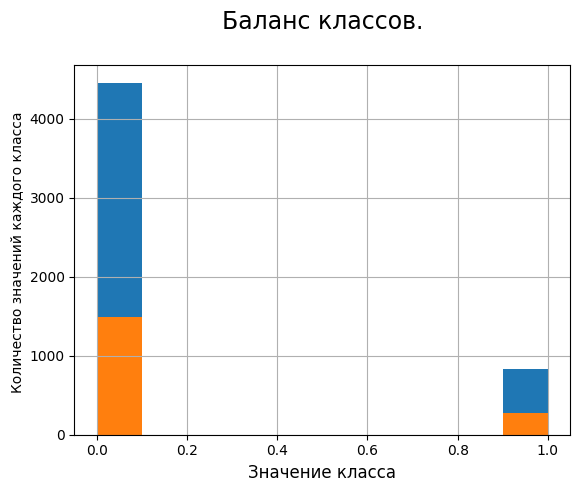

In [62]:
y_train.hist()
y_test.hist()

plt.title('Баланс классов.' + "\n", fontsize=17)
plt.xlabel('Значение класса', fontsize=12)
plt.ylabel('Количество значений каждого класса ', fontsize=10);

Всё хорошо, в каждой выборки имеются целевые признаки каждой из двух категорий.
Подготовим функцию и пустой список для записи и просмотра результатов, работы модели.

### функции под модели

In [63]:
def results(model):
    best_params = model.best_params_
                                                
    model_table = pd.DataFrame(model.cv_results_)
    model_table = model_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
    model_table = model_table[model_table['params']==best_params]

    model_table = model_table.rename(columns={ 
        'mean_fit_time':'Learning time', 
        'mean_score_time':'Prediction time',
        'params':'Parameters',
        'mean_test_score':'AUC-ROC'})

    return model_table.reset_index(drop=True)

In [64]:
result = []

Посмотрим на константную модель и её результат, для проверки на адекватность.

#### DummyClassifier

In [65]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
dummy_predict = dummy.predict(X_test)
print('AUC-ROC constant', (roc_auc_score(y_test, dummy_predict)))

AUC-ROC constant 0.5


In [66]:
result.append(roc_auc_score(y_test, dummy_predict))

Минимальный результат на адекватность 0.5 в задании для принятия модели требуется AUC_ROC не менее 0.88. теперь у нас есть рамки можем приступать к обучению.

#### LogisticRegression

In [67]:
model_lr = LogisticRegression(random_state=RANDOM)

parameters = { 
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter' : [50, 100, 500, 1000],
    'class_weight': ['balanced', None] }

In [68]:
grid = GridSearchCV(model_lr,parameters, scoring = 'roc_auc', cv=3, verbose=False,  n_jobs=-1)
grid.fit(X_train, y_train)
result.append(grid.best_score_)

results(grid)

,Learning time,Prediction time,Parameters,AUC-ROC
0,0.368979,0.011334,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.742233


#### RandomForestClassifier

In [69]:
model_rfc = RandomForestClassifier(random_state=RANDOM)

parameters_rfc = { 
    'n_estimators': [10, 50, 100, 200,1000],
    'max_depth' : [2, 5, 6, 7, 8, 9, 10],
    'class_weight': ['balanced', None]
}


grid_rfc = GridSearchCV(model_rfc, parameters_rfc, scoring = 'roc_auc', cv=5,  n_jobs=-1)
grid_rfc.fit(X_train, y_train)

result.append(grid_rfc.best_score_)
results(grid_rfc)

,Learning time,Prediction time,Parameters,AUC-ROC
0,10.241037,0.398233,"{'class_weight': 'balanced', 'max_depth': 7, '...",0.80363


#### LGBMClassifier

In [70]:
lgbm_model = LGBMClassifier(random_state=RANDOM,
                             class_weight='balanced',
                             silent=True)

In [71]:
lgbm_params =   {'n_estimators': [300, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}



grid_lgbm = GridSearchCV(lgbm_model,
                             lgbm_params,
                             cv=5,
                             scoring = 'roc_auc',
                             n_jobs=-1,
                             verbose=False).fit(X_train, y_train)

result.append(grid_lgbm.best_score_)
results(grid_lgbm)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: 

,Learning time,Prediction time,Parameters,AUC-ROC
0,11.976196,0.016801,"{'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_...",0.877294


#### CatBoostClassifier

In [72]:
cat_model = CatBoostClassifier(random_state=RANDOM, auto_class_weights='Balanced', loss_function='Logloss', silent=True)

In [73]:
parameters_cat = {'n_estimators': [100, 300, 500, 1000],
                  'learning_rate': [ 0.1, 0.5, 1, 2],
                  'max_depth': [2, 3, 4, 5],
                  'l2_leaf_reg': [1, 3, 4]}



grid_cat = GridSearchCV(cat_model,
                        parameters_cat,
                        cv = 10,
                        verbose=False,
                        n_jobs=-1,
                        scoring = 'roc_auc')

grid_cat.fit(X_train, y_train)

result.append(grid_cat.best_score_)
results(grid_cat)

,Learning time,Prediction time,Parameters,AUC-ROC
0,2.295405,0.00831,"{'l2_leaf_reg': 4, 'learning_rate': 0.5, 'max_...",0.91677


### Выбор лучшей модели

Посмотрим, на результаты работы всех наших моделей.

In [73]:
pd.DataFrame(data=result,
             index=['DummyClassifier','LogisticRegression','RandomForestClassifier', 'LightGBM', 'CatBoost'],
             columns=['AUC-ROC'])

,AUC-ROC
DummyClassifier,0.500000
LogisticRegression,0.742233
RandomForestClassifier,0.803630
LightGBM,0.877294
CatBoost,0.916770


Наиболее перспективной с лучшим результатом **AUC_ROC** ~0.92 модель *CatBoostClassifier*. Её мы и возьмем для контрольной проверке на тестовой выборке.

### Оценка модели

Посмотрим на результат предсказаний нашей модели на тестовой выборке.

In [74]:
top_cat = grid_cat.best_estimator_
final = roc_auc_score(y_test,top_cat.predict_proba(X_test)[:, 1])
print("AUC-ROC: %.2f" % final)

AUC-ROC: 0.93


Очень неплохой результат, мы прошли наш минимальный порог требуемый заказчиком.

### Матрица ошибок и ROC кривая

#### AUC_ROC

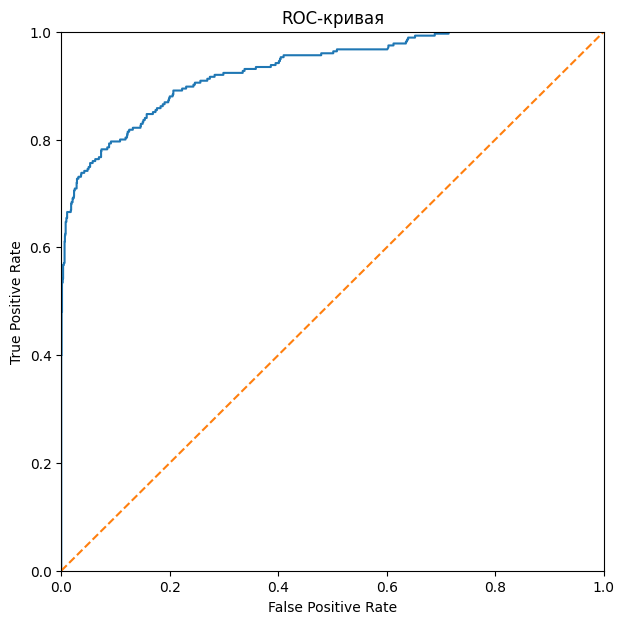

AUC-ROC: 0.93


In [76]:
fpr, tpr, thresholds = roc_curve(y_test, top_cat.predict_proba(X_test)[:, 1])

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
print("AUC-ROC: %.2f" % final)

Видим, что модель предсказывала неслучайно. Наша модель показала себя хорошо, AUC-ROC на тесте составляет 0,93.

#### Confusion matrix

Загрузим картинку как выглядит матрица ошибок.

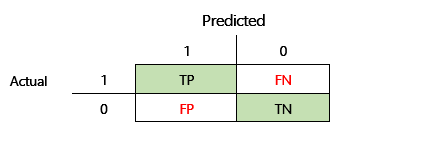

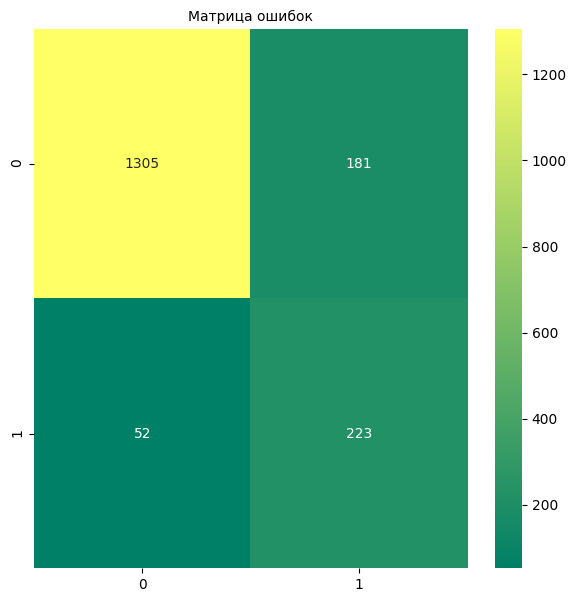

In [77]:
predict = top_cat.predict(X_test)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix(y_test, predict),annot=True,fmt='1.0f',cmap="summer")
plt.title('Матрица ошибок', y=1., size=10);

Отлично, модель очень мало ошибалась. Всего около 13% ошибок от всей тестовой выборке.

Посмотрим на значимость признаков для нашей модели.

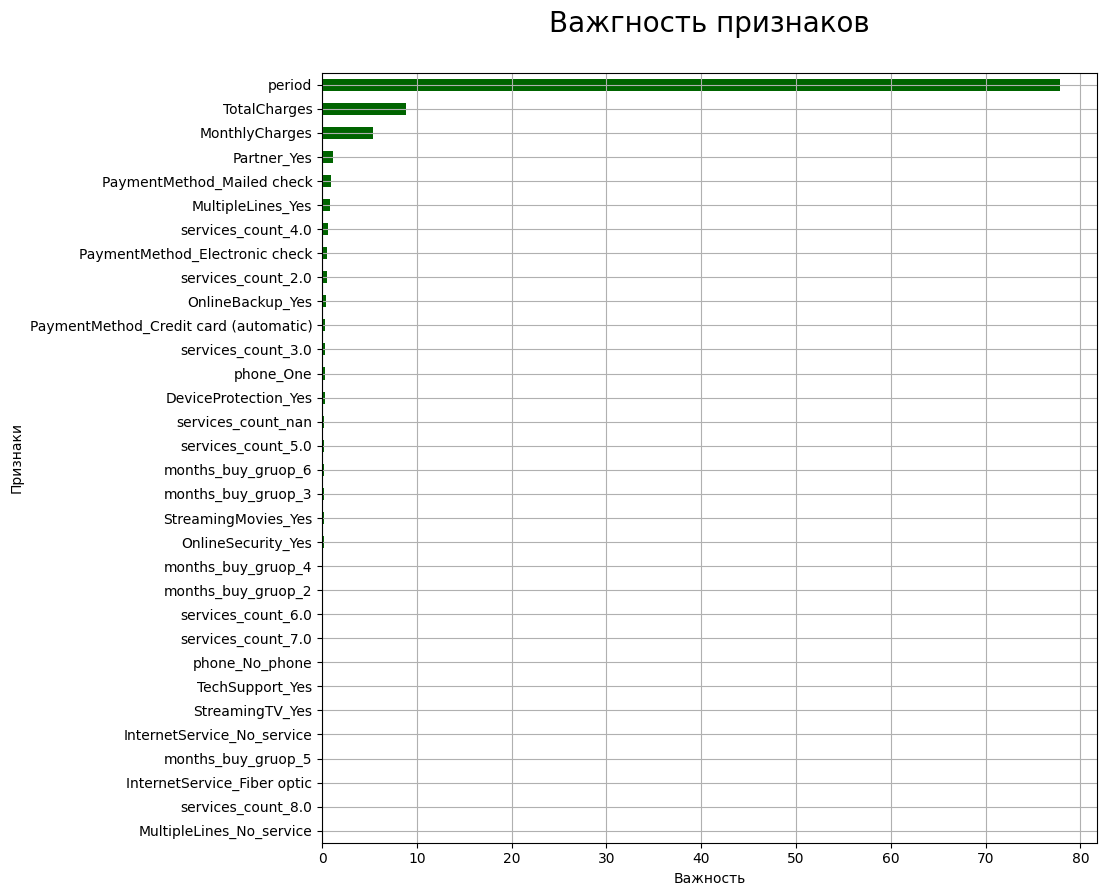

In [78]:
features_names = X_train.columns.to_list()
importances = top_cat.feature_importances_

lgbm_importances = pd.Series(importances, index=features_names).sort_values()
lgbm_importances.plot(kind='barh', grid=True, legend = False, figsize=(10,10), fontsize = 10, color='DarkGreen')

plt.title('Важгность признаков'+'\n', fontsize = 20)
plt.xlabel('Важность', fontsize = 10)
plt.ylabel('Признаки', fontsize = 10)
plt.show()


Главными тремя признаками для нашей модели стали *period, TotalCharges, MonthlyCharges* то сколько клиент провёл с нами время, сколько было выплат и ежемесячный платёж. Оставшиеся значимость разделилась между 17 признаков из 32. Последние 12 практически не имеют значения. 

### Общий вывод и рекомендации заказчику

В ходе исследования были проанализированы четыре набора данных, содержащих информацию о договорах с пользователями, количестве используемых ими сервисов и семейном положении. Все наборы данных были объединены в один большой, с которым и проводилась работа. Бинарный целевой признак был подготовлен, выявив явный дисбаланс классов в пользу пользователей, остающихся клиентами. На основе имеющихся данных были созданы дополнительные признаки, такие как количество дней использования услуг, на основе чего были выделены группы по годам. Также были сформированы группы по ежемесячной плате и количеству дополнительных услуг. Дополнительно был собран признак по общему количеству используемых сервисов (интернет, телефон и другие).

Была проведена оценка корреляции всех признаков с целевым признаком и между собой. Данные были разделены на учебную и тестовую выборки, закодированы и масштабированы для наилучшего обучения моделей.

Было обучено четыре модели: LogisticRegression, RandomForestClassifier, LightGBM, CatBoost с подбором гиперпараметров. Лучшую метрику AUC-ROC показала модель CatBoost, которую мы выбрали для финальной тестовой выборки. Модель выполнила свою задачу, продемонстрировав AUC-ROC 0.93, что является хорошим показателем для наших исследований и соответствует минимальным требованиям заказчика (0.85). ROC-кривая подтвердила, что модель справляется со своей задачей, а не предсказывает одно и то же. Матрица ошибок показала, что модель не идеальна и следует поработать над ошибками негативных предсказаний (FN). В целом модель совершила порядка 13% ошибок (FN, FP). Значимость признаков выявила наиболее важные для модели факторы, а именно количество дней использования услуг, общую сумму, уплаченную пользователем, ежемесячную плату по договору, и семейное положение клиента.

Данная модель отлично подходит для предсказания ухода клиента. Основываясь на её выводах, можно рассмотреть предложения скидок для уменьшения ежемесячной платы или бонусы в зависимости от общей суммы, уплаченной пользователем за время пользования услугами.624

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА 2</b></u></p>
ОК, Данила, теперь точно можно сказать, что пройден весь алгоритм моделирования от анализа исходной инфо до анализа важности факторов. <br>Увидел твои комментари/коорректировки. ОК.<br> По метрике: она высокая вышла, но ошибок, вроде, не наблюдается. С факторами - ОК, с категоризаццией - ОК, стратификация и предикт_проба на месте)<br>

Далее, мне бы хотелось ещё раз зафиксировать моменты, важные для моделирования:<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- Оцениваем мультиколлинеарность.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.<br><br><br>

 
Каждого из нас (и меня в том числе) можно оценивать с нескольких сторон, как специалиста.<br>
1) Умение анализировать, "вгрызание" в данные, в задачу.<br>
2) Знание мат.части: методы, подходы к решению - всё, что по программе заложено<br>
3) Кодовая часть: умение писать эффективный код.<br>
4) Работа с графикой. (умение хорошо ыизуализировать)<br>
И при рабочей деятельности (устраивание на работу/ улучшение карьеры) на важно понимать свои слабые/сильные стороны по этим направлениям. И опираться на них при ведении переговоров и выстраивании дальнейшего совершенствования. Желаю и дальше развиваться в профессиональной аналитике.<br><br>    
      
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br> 